In [2]:
library(quantmod)
library(forecast)
library(tseries)
library(rugarch)

Caricamento del pacchetto richiesto: xts

Caricamento del pacchetto richiesto: zoo


Caricamento pacchetto: ‘zoo’


I seguenti oggetti sono mascherati da ‘package:base’:

    as.Date, as.Date.numeric


Caricamento del pacchetto richiesto: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Caricamento del pacchetto richiesto: parallel


Caricamento pacchetto: ‘rugarch’


Il seguente oggetto è mascherato da ‘package:stats’:

    sigma




In [3]:
#preprocessing
getSymbols("SPY", src = "yahoo", from = "2010-01-01", to = Sys.Date())
spy_prices <- Cl(SPY)
log_prices <- log(spy_prices)
diff_log_prices <- diff(log_prices)#*100#to avoid optimizer issues
diff_log_prices <- na.omit(diff_log_prices)

[1] "SPY"

### Analisi esplorativa
Come prima cosa è opportuno plottare la serie temporale dei prezzi e il logaritmo dei prezzi. Inoltre è utile plottare la serie differenziata del logaritmo dei prezzi, su cui verificheremo l'ipotesi di stazionarietà debole. Come ultimo plot poi verificheremo l'aderenza della distribuzione dei prezzi logaritmici differenziati alla normale


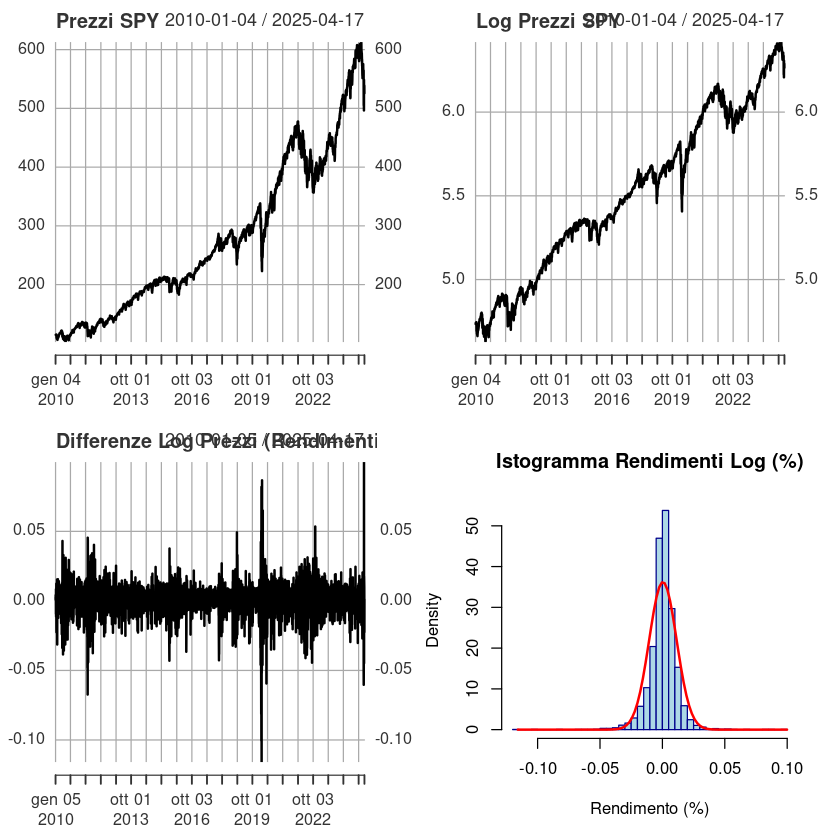

In [121]:
par(mfrow = c(2,2))
plot(spy_prices, main = "Prezzi SPY")
plot(log_prices, main = "Log Prezzi SPY")
plot(diff_log_prices, main = "Differenze Log Prezzi (Rendimenti, in %)")
diff_log_prices_num <- as.numeric(diff_log_prices)
hist(diff_log_prices_num, breaks = 50, probability = TRUE,
     main = "Istogramma Rendimenti Log (%)", 
     xlab = "Rendimento (%)", col = "lightblue", border = "darkblue")
x_vals <- seq(from = min(diff_log_prices_num), to = max(diff_log_prices_num), length.out = 100)
dens_vals <- dnorm(x_vals, mean = mean(diff_log_prices_num), sd = sd(diff_log_prices_num))
lines(x_vals, dens_vals, col = "red", lwd = 2)
par(mfrow = c(1,1))

### Verifica della stazionarietà (debole) della serie
Utilizzando l'Augmented Dickey-Fuller test, che suppone la non stazionarietà come ipotesi nulla possiamo capire se la serie è stazionaria in senso debole, condizione necessaria per l'applicazione di qualsiasi modello arima.

In [31]:
adf_result <- adf.test(diff_log_prices)
print(adf_result)

Warning message in adf.test(diff_log_prices):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  diff_log_prices
Dickey-Fuller = -16.386, Lag order = 15, p-value = 0.01
alternative hypothesis: stationary



Come ci aspettavamo la serie è debolmente stazionaria. Questo permette di poter trovare un modello arima per stimare la parte di medie e valutarne la parte di residui. Come prima cosa andiamo a plottare ACF e PACF per i rendimenti differenziati, che possono suggerire informazioni sugli ordini di AR e MA.

#### ACF
Misura la correlazione tra una serie temporale e se stessa spostata di un lag. Indica quanto è forte la correlazione tra $X_t$ e $X_{t-k}$. Quando l'ACF si azzera, la correlazione si annulla e questo suggerisce l'ordine della componente MA del modello.

#### PACF
Misura la correlazione diretta tra la serie e le sue versioni ritardate al lag $k$, controllando l'effetto dei lag intermenti. Fornisce l'autocorrelazione tra $X_t$ e $X_{t-k}$ quando si tengono costanti i restanti valori. Questo è particolarmente utile per determinare l'ordine della componente AR in un modello arima.


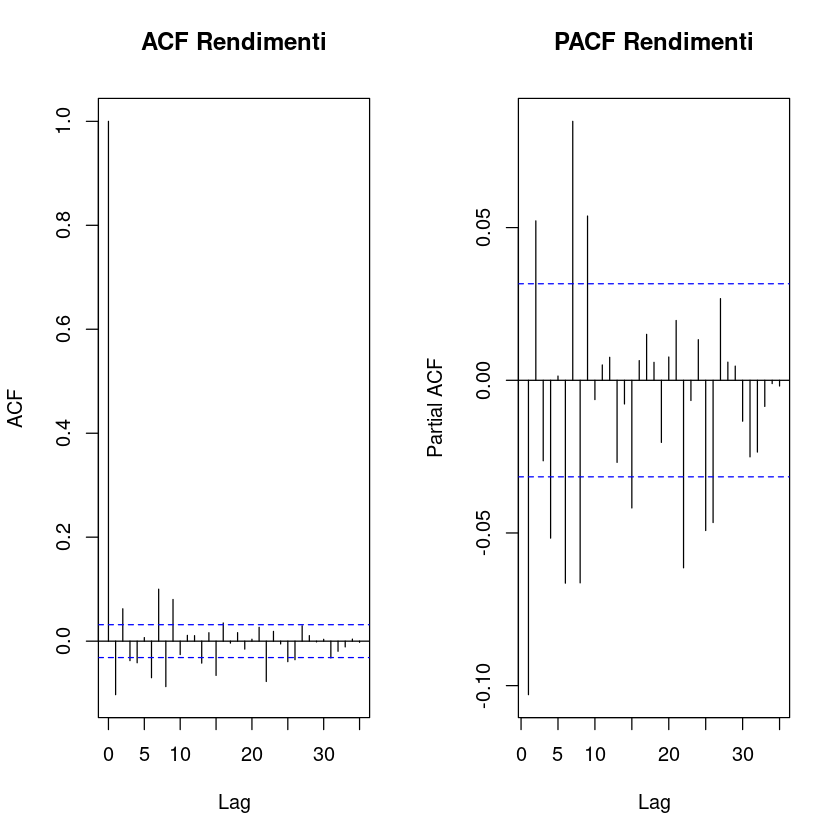

In [32]:
par(mfrow = c(1,2))
acf(diff_log_prices, main = "ACF Rendimenti")
pacf(diff_log_prices, main = "PACF Rendimenti")
par(mfrow = c(1,1))

Possiamo ora stimare i modelli ARIMA. Utilizzeremo per la ricerca modelli con $ p,q \leq 2$ per evitare overfitting e rendere l'interpretazione piu chiara. Questo ci permette di confrontare direttamente i modelli tramite criteri informativi come l'AIC, oltre ad ottenere una stima più stabile dei parametri.

In [122]:
#model named with 1 as integrating param due to preprocess
model_111 <- arima(diff_log_prices, order = c(1,0,1))
model_211 <- arima(diff_log_prices, order = c(2,0,1))
model_121 <- arima(diff_log_prices, order = c(1,0,2))
model_212 <- arima(diff_log_prices, order = c(2,0,2))
model_011 <- arima(diff_log_prices, order = c(0,0,1))
model_100 <- arima(diff_log_prices, order = c(1,0,0))
#aic index
cat("AIC modello ARIMA(1,1,1):", AIC(model_111), "\n")
cat("AIC modello ARIMA(2,1,1):", AIC(model_211), "\n")
cat("AIC modello ARIMA(1,1,2):", AIC(model_121), "\n")
cat("AIC modello ARIMA(2,1,2):", AIC(model_212), "\n")
cat("AIC modello ARIMA(0,1,1):", AIC(model_011), "\n")


AIC modello ARIMA(1,1,1): -23806.12 
AIC modello ARIMA(2,1,1): -23806.07 
AIC modello ARIMA(1,1,2): -23806.65 
AIC modello ARIMA(2,1,2): -23875.3 
AIC modello ARIMA(0,1,1): -23794.98 


Possiamo notare come il modello ARIMA(2,1,2) abbia AIC più basso e quindi sia il migliore per modellizzare la parte di media della nostra serie temporale. Siamo interessati ora a visualizzare i residui.

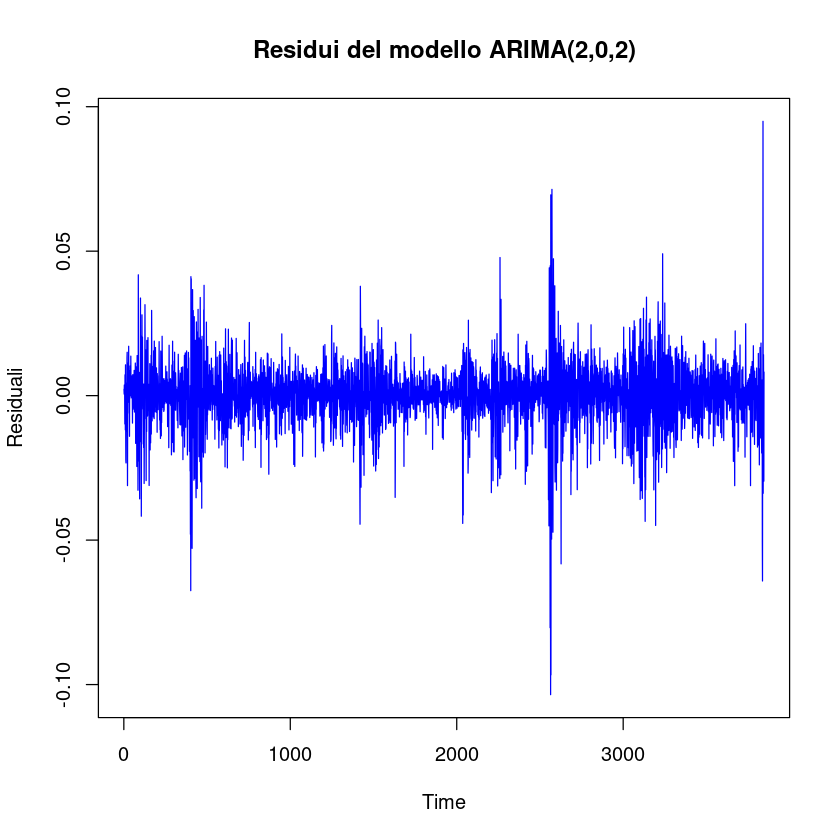

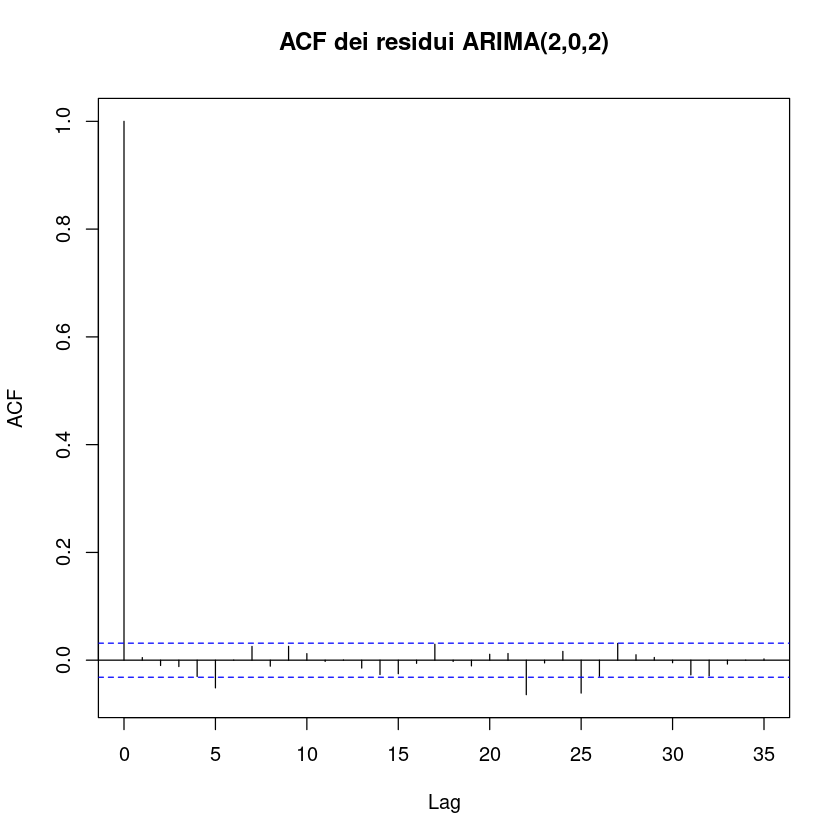

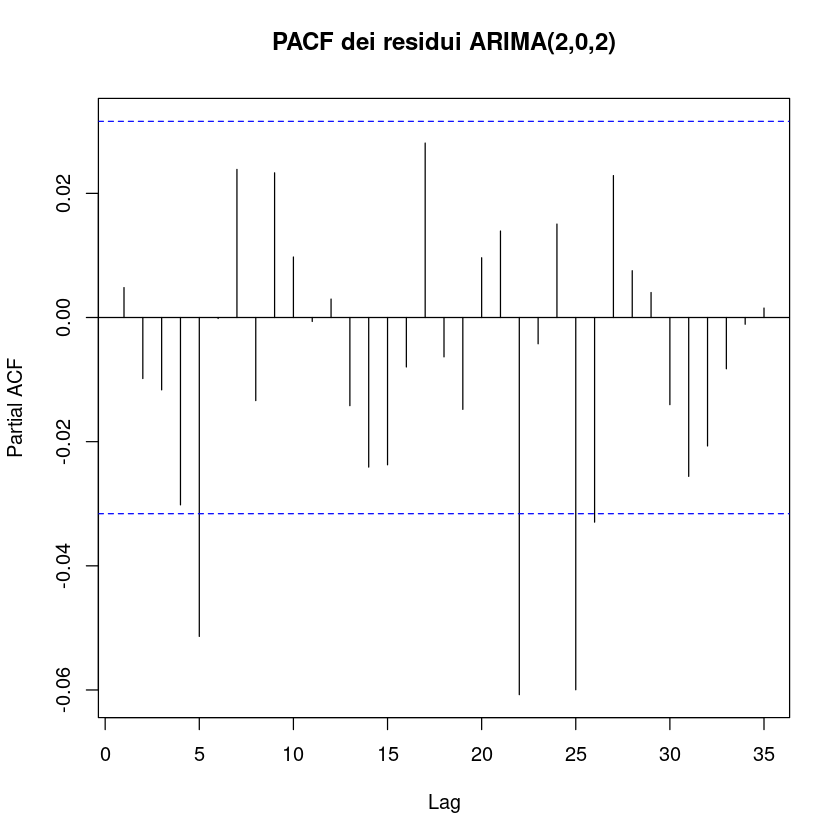

In [123]:
res_212 <- residuals(model_212)
#plot
plot(res_212, 
     main = "Residui del modello ARIMA(2,0,2)", 
     ylab = "Residuali", 
     col = "blue")
acf(res_212, 
    main = "ACF dei residui ARIMA(2,0,2)")   

pacf(res_212, 
     main = "PACF dei residui ARIMA(2,0,2)") 


### Autocorrelazione dei residui

Possiamo ora utilizzare il test Ljung-Box per verificare se i residui del modello mostrano autocorrelazioni significative fino ad un certo numero di lag. Il test confronta le autocorrelazioni osservate nei residui con quelle attese per una serie casuale. Questo permette di valutare eventuali effetti di clustering della volatilità per cui sarebbe ragionevole utilizzare un modello ARCH/GARCH.

In [ ]:
#test on residuals
lb_test <- Box.test(res_212, lag = 20, type = "Ljung-Box")
cat("Ljung-Box test sui residui:\n")
print(lb_test)
#test on square residuals for ARCH/GARCH
lb_test_sq <- Box.test(res_212^2, lag = 20, type = "Ljung-Box")
cat("Ljung-Box test sui residui^2 (per effetti ARCH):\n")
print(lb_test_sq)

Ljung-Box test sui residui:



	Box-Ljung test

data:  diff_log_prices
X-squared = 202.27, df = 20, p-value < 2.2e-16



ERROR: Error: oggetto 'res_212' non trovato


I p-value bassi confermando l'idea iniziale : il p-value sui residui standard non permette di rifiutare l'ipotesi nulla, ovvero globalmente i residui non mostrano autocorrelazione significativa. La parte ARIMA ha dunque catturato in maniera efficace la struttura media della serie.
Tuttavia questo test valuta solo la parte lineare della serie e non la struttura della volatilità che viene efficacemente catturata dal secondo test effettuato, ovvero quello dei residui al quadrato. Infatti nel test dei residui al quadrato dobbiamo rifiutare l'ipotesi nulla, ammettendo l'esistenza di una forte correlazione. Questo è un segnale tipico di clustering della volatilità che motiva la necessità di implementare una componente ARCH/GARCH per modellizzare la varianza in modo condizionale.

In [80]:
spec_garch <- ugarchspec(
    variance.model = list(model="sGARCH", garchOrder = c(1,1)),
    mean.model = list(armaOrder = c(0,0), include.mean=FALSE),
    distribution.model = "norm"
)
#garch estimation
garch_fit <-ugarchfit(spec = spec_garch, data = as.numeric(res_212))
summary(garch_fit)
log_lik <- garch_fit@fit$LLH
num_param <- length(garch_fit@fit$coef)
aic <- -2*log_lik + 2*num_param
cat("AIC per GARCH(1,1): ",aic, ".\n")

   Length     Class      Mode 
        1 uGARCHfit        S4 

AIC per GARCH(1,1):  -25387.3 .


In [81]:
std_resid_normal <- garch_fit@fit$residuals/garch_fit@fit$sigma #std deviation
shapiro_test <- shapiro.test(std_resid_normal)
print(shapiro_test)


	Shapiro-Wilk normality test

data:  std_resid_normal
W = 0.97472, p-value < 2.2e-16



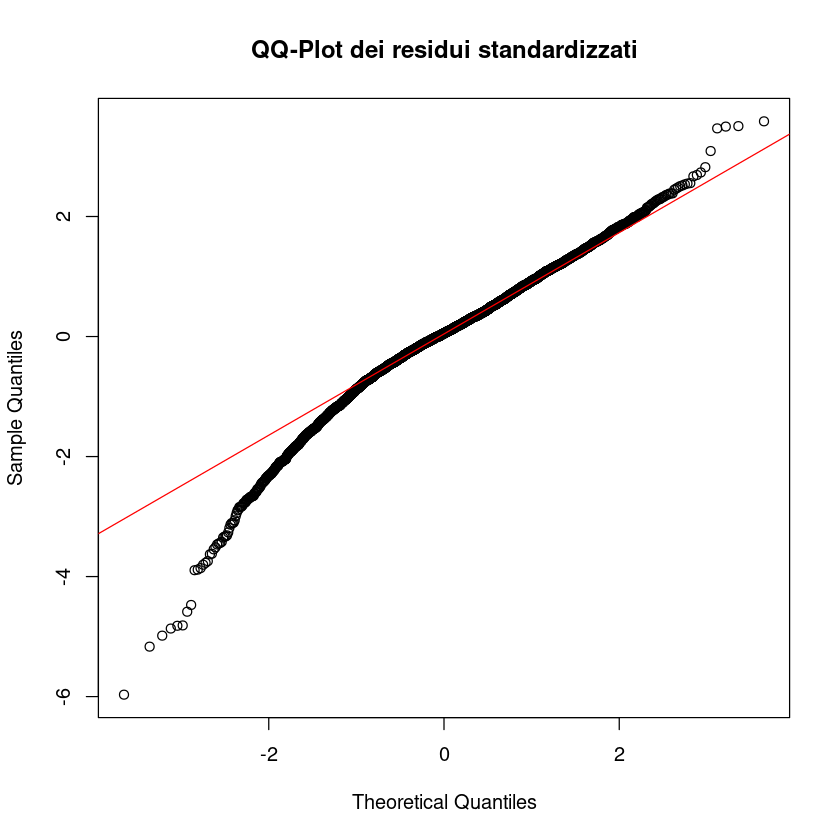

In [82]:
qqnorm(std_resid_normal, main="QQ-Plot dei residui standardizzati")
qqline(std_resid_normal, col="red")


### Normalità dei residui standardizzati

I due test rifiutano l'ipotesi di normalità dei residui standardizzati. Infatti, il test di normalità di Shapiro-Wilk presenta un p-value molto basso e dobbiamo quindi rifiutare l'ipotesi nulla. Questo rifiuto viene corroborato dal test qualitativo del QQ-plot: notiamo infatti come la coda di sinistra si discosti significativamente dalla diagonale ideale della normale. Possiamo quindi dedurre che le code siano più pesanti e asimmetriche rispetto ad una distribuzione normale. Verifichiamo queste ipotesi andando a controllare la skewness e la kurtosis dei rendimenti logaritmici e dei residui standardizzati.

Return skewness:  -0.5584354 .
Standardized residuals skewness:  -0.6417484

In [ ]:
library(moments)
# number of observations for returns
n_ret <- length(diff_log_prices)
se_ret <- sqrt(6 / n_ret)

# skewness e z-score for returns
skew_ret <- skewness(diff_log_prices)
z_ret    <- skew_ret / se_ret
p_ret    <- 2 * pnorm(-abs(z_ret))

cat("Return skewness:", skew_ret, "\n")
cat("  z-score:", z_ret,   "\n")
cat("  p-value:", p_ret,   "\n\n")

# number of observations for residuals
std_resid_num <- as.numeric(std_resid_normal)
n_res <- length(std_resid_num)
se_res <- sqrt(6 / n_res)

# skewness e z-score for std residuals
skew_res <- skewness(std_resid_num)
z_res    <- skew_res / se_res
p_res    <- 2 * pnorm(-abs(z_res))

cat("Std. residuals skewness:", skew_res, "\n")
cat("  z-score:", z_res,       "\n")
cat("  p-value:", p_res,       "\n")


Return skewness: -0.5584354 
  z-score: -14.13846 
  p-value: 2.200615e-45 

Std. residuals skewness: -0.6417484 
  z-score: -16.24143 
  p-value: 2.568498e-59 


Notiamo quindi che sia i rendimenti logaritmici che i residui standardizzati presentano asimmetrie negative, tipiche degli andamenti finanziari. La distribuzione dei rendimenti (e conseguentemente dei residui) ha una coda a sinistra più pesante, ovvero occasionalmente ci sono rendimenti negativi più estremi rispetto alla media. Questa ipotesi è corroborata dallo z-score e p-value, che indicano che questa skewness (seppur moderata) è altamente significativa. 



### t di Student
Inizialmente possiamo ipotizzare una t di Student come distribuzione per le volatilità condizionate nel modello GARCH, che dovrebbe mitigare almeno in parte il problema delle code pesanti. Andremo poi a valutare l'impatto di una skewed-t come distribuzione per il GARCH.

In [ ]:
spec_garch <- ugarchspec(
    variance.model = list(model="sGARCH", garchOrder = c(1,1)),
    mean.model = list(armaOrder = c(0,0), include.mean=FALSE),
    distribution.model = "std"
)
#garch estimation
garch_fit <-ugarchfit(spec = spec_garch, data = as.numeric(res_212))
summary(garch_fit)
log_lik <- garch_fit@fit$LLH
num_param <- length(garch_fit@fit$coef)
aic <- -2*log_lik + 2*num_param
cat("AIC per student t: ",aic, ".\n")

   Length     Class      Mode 
        1 uGARCHfit        S4 

AIC per GARCH(1,1):  -25586.12 .


Possiamo già notare dall'AIC come questo modello sia preferibile al precedente. Tuttavia è interessante valutare come i residui si adattino ad una t di Student con grado di libertà stimato dal modello.

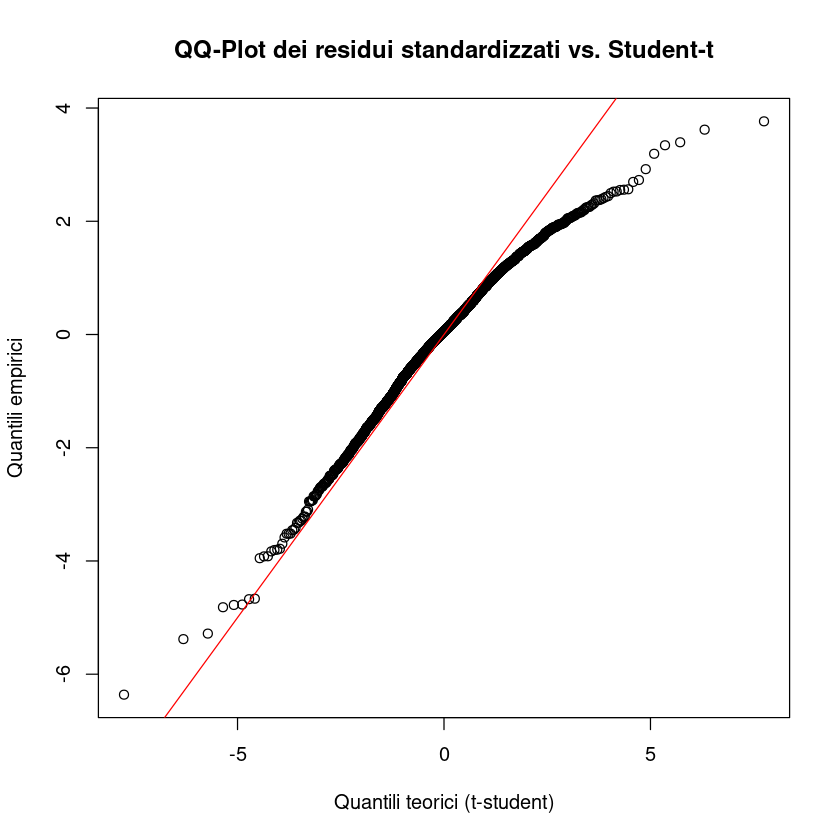

In [92]:
std_resid_t <- residuals(garch_fit, standardize = TRUE)
std_resid_t <- as.numeric(coredata(std_resid_t))
#freedom degrees
df <- as.numeric(garch_fit@fit$coef[["shape"]])
#theorical distribution
theo_q <- qt(ppoints(length(std_resid_t)),df = df)
qqplot(theo_q, std_resid_t, 
       main = "QQ-Plot dei residui standardizzati vs. Student-t",
       xlab = "Quantili teorici (t-student)",
       ylab = "Quantili empirici")
abline(0, 1, col = "red")

In [ ]:
spec_garch <- ugarchspec(
    variance.model = list(model="sGARCH", garchOrder = c(1,1)),
    mean.model = list(armaOrder = c(0,0), include.mean=FALSE),
    distribution.model = "std"
)
#garch estimation
garch_fit <-ugarchfit(spec = spec_garch, data = as.numeric(res_212))
summary(garch_fit)
log_lik <- garch_fit@fit$LLH
num_param <- length(garch_fit@fit$coef)
aic <- -2*log_lik + 2*num_param
cat("AIC per student t: ",aic, ".\n")

   Length     Class      Mode 
        1 uGARCHfit        S4 

AIC per GARCH(1,1):  -25586.12 .


### Migliore fit rispetto alla normale

Nel nuovo QQ-plot notiamo che i residui aderiscono meglio alla diagonale dei quantili teorica. Le deviazioni risultano attenuate rispetto al QQ-plot della normale, suggerendo una modellizzazione più efficace delle caratteristiche della serie.

### Skewed t
Ora vogliamo verificare l'effetto di una t di Student assimetrica (abbiamo precedentemente dimostrato che l'assimetria moderata è statisticamente significativa) sul modello (AIC) e sul QQ-plot.
 

In [191]:
#sstd
spec_garch_sstd <- ugarchspec(
  variance.model = list(model = "sGARCH", garchOrder = c(1,1)),
  mean.model     = list(armaOrder = c(2,2), include.mean = FALSE),
  distribution.model = "sstd"
)
garch_fit_sstd <- ugarchfit(spec = spec_garch_sstd, data = as.numeric(res_212))
aic_sstd <- -2*garch_fit_sstd@fit$LLH + 2*length(garch_fit_sstd@fit$coef)
cat("AIC skewed t:",aic_sstd,".\n")


AIC skewed t: -25696.19 .


Notiamo come l'AIC per il modello sia migliore rispetto al modello precendente. Ora possiamo valutare il QQ-plot.

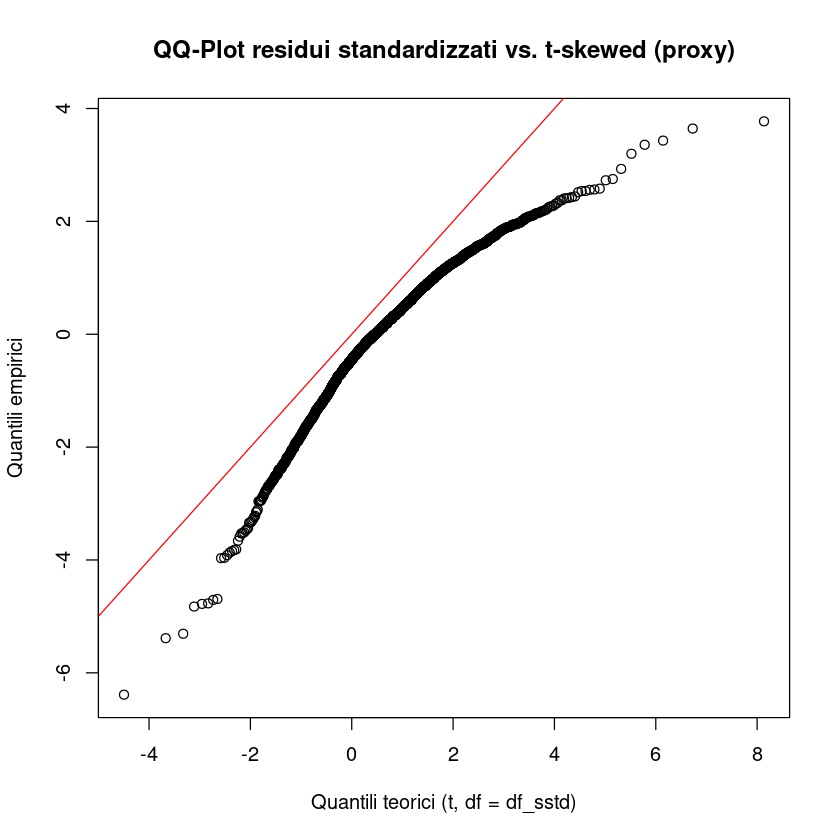

In [128]:
library(sn)
std_resid_sstd <- residuals(garch_fit_sstd, standardize = TRUE)
std_resid_sstd <- as.numeric(coredata(std_resid_sstd))
#qqplot with skewness and freedom degrees
params <-garch_fit_sstd@fit$coef
df_sstd <- as.numeric(params["shape"])
skew_sstd <- as.numeric(params["skew"])
#theorical quantiles
theo_q_sstd <- qst(ppoints(length(std_resid_sstd)), alpha = skew_sstd, nu = df_sstd)
#qqplot
qqplot(theo_q_sstd, std_resid_sstd, 
       main = "QQ-Plot residui standardizzati vs. t-skewed (proxy)",
       xlab = "Quantili teorici (t, df = df_sstd)",
       ylab = "Quantili empirici")
abline(0,1, col = "red")


Il QQ-plot risulta qualitativamente peggiore rispetto al caso della t di Student normale. Tuttavia, è necessario valutare i risultati in termini di forecasting. Se i risultati sono più robusti, andremo a preferire il secondo modello e la mancata aderenza del QQ-plot potrebbe non essere determinante, in quanto il secondo modello dovrebbe descrivere globalmente i dati in maniera più efficace.

Possiamo utilizzare un modello EGARCH per valutarne l'AIC. Esso introduce un termine asimmetrico per modellare la volatilità in periodi di shock positivi o negativi. La varianza viene modellizzata in scala logaritmica e utilizza un parametro $\gamma\frac{\epsilon_{t-1}}{\sigma_{t-1}}$ per modellare gli shock.

In [ ]:
# egarch with skewed t
spec_eGARCH <- ugarchspec(
  variance.model = list(model = "eGARCH", garchOrder = c(1,1)),
  mean.model = list(armaOrder = c(0,0), include.mean = FALSE),
  distribution.model = "std"  
)

egarch_fit <- ugarchfit(spec = spec_eGARCH, data = as.numeric(res_212))

print(summary(egarch_fit))

   Length     Class      Mode 
        1 uGARCHfit        S4 


In [130]:
aic <- -2*egarch_fit@fit$LLH + 2*length(egarch_fit@fit$coef)
print(aic)

[1] -25771.74


Possiamo utilizzare un altro tipo di modello GARCH. Il GJR modella in maniera diversa gli shock introducendo un termine $\gamma$ che introduce un effetto extra sulla volatilità solo se lo shock è negativo.

In [203]:
# gjr garch
spec_gjr <- ugarchspec(
  variance.model = list(model = "gjrGARCH", garchOrder = c(1,1)),
  mean.model = list(armaOrder = c(1,1), include.mean = TRUE),
  distribution.model = "sstd"
)

gjr_fit <- ugarchfit(spec = spec_gjr, data = as.numeric(diff_log_prices))

print(summary(gjr_fit))


   Length     Class      Mode 
        1 uGARCHfit        S4 


In [162]:
print(length(diff_log_prices))

[1] 3846


In [142]:
aic <- -2*gjr_fit@fit$LLH + 2*length(gjr_fit@fit$coef)
print(aic)

[1] -25871.63


Tra tutti i modelli proposti il GJR risulta il più efficace in termini di aic. Facciamo una visualizzazione completa delle sue caratteristiche e dei residui prodotti dal modello.

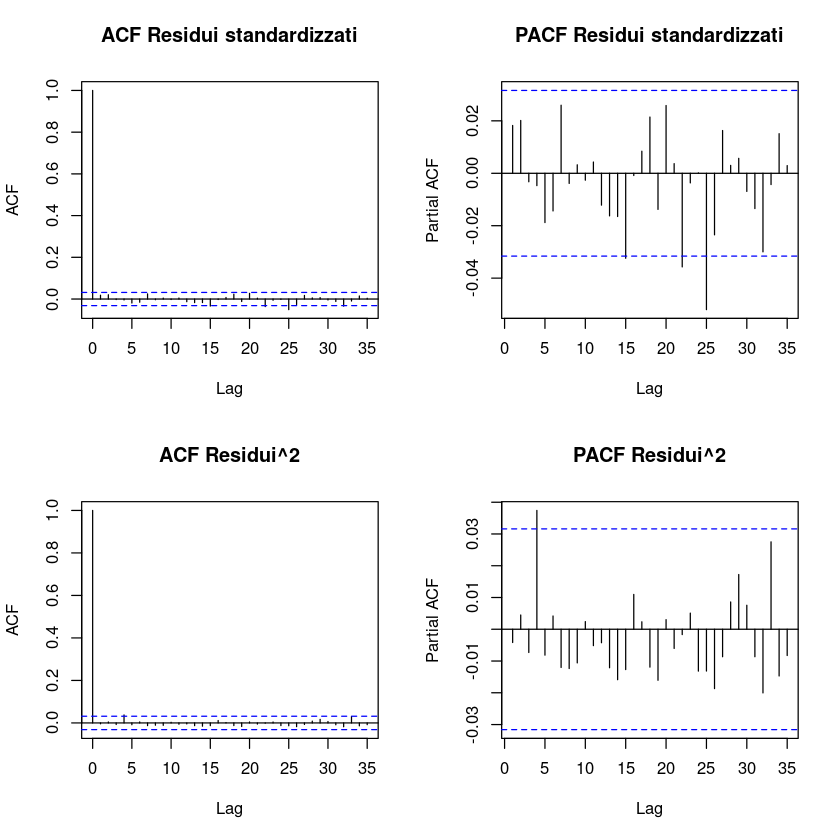


	Box-Ljung test

data:  std_resid_gjr
X-squared = 20.852, df = 20, p-value = 0.4059


	Box-Ljung test

data:  std_resid_gjr^2
X-squared = 12.368, df = 20, p-value = 0.9028



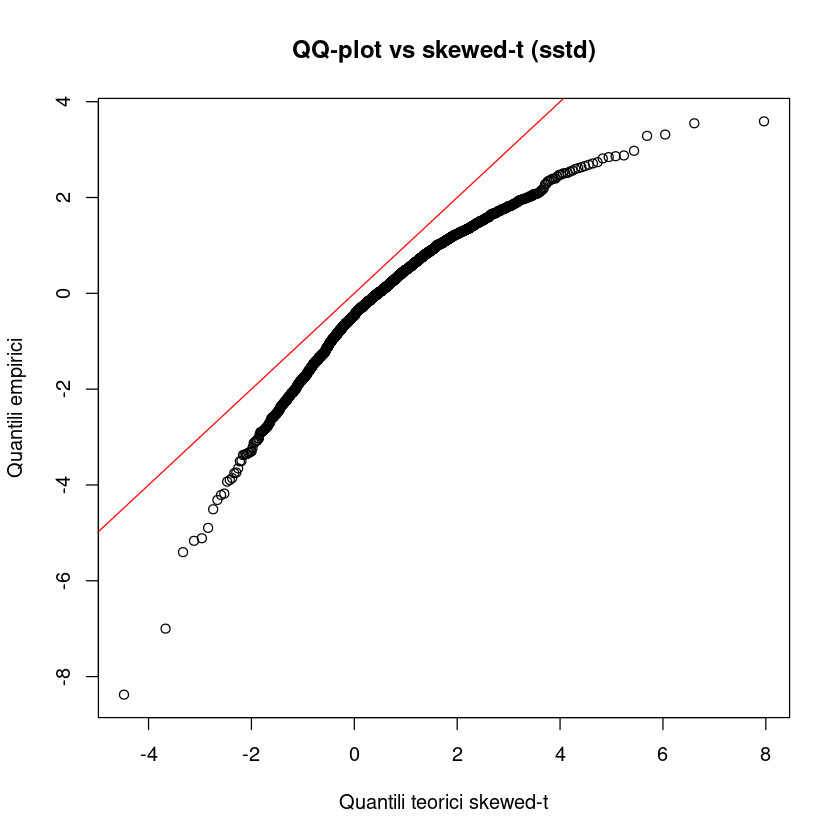

In [149]:

library(rugarch)
library(moments)     # skewness, kurtosis
library(tseries)     # jarque.bera.test
library(sn)          # qst() for skewed t

std_resid_gjr <- residuals(gjr_fit, standardize = TRUE)
std_resid_gjr <- as.numeric(coredata(std_resid_gjr))

#acf and pacf for residuals in case we missed something
par(mfrow = c(2,2))
acf(std_resid_gjr,         main = "ACF Residui standardizzati")
pacf(std_resid_gjr,        main = "PACF Residui standardizzati")
acf(std_resid_gjr^2,       main = "ACF Residui^2")
pacf(std_resid_gjr^2,      main = "PACF Residui^2")
par(mfrow = c(1,1))

# QQ-plot with skewed t
params   <- gjr_fit@fit$coef
nu       <- as.numeric(params["shape"])
alpha    <- as.numeric(params["skew"])
p_pts    <- ppoints(length(std_resid_gjr))
theo_q    <- qst(p_pts, xi = 0, omega = 1, alpha = alpha, nu = nu)

qqplot(theo_q, std_resid_gjr,
       main = "QQ‑plot vs skewed‑t (sstd)",
       xlab = "Quantili teorici skewed‑t",
       ylab = "Quantili empirici")
abline(0, 1, col = "red")


#ljung-box test    
lb1 <- Box.test(std_resid_gjr,   type = "Ljung-Box", lag = 20)
lb2 <- Box.test(std_resid_gjr^2, type = "Ljung-Box", lag = 20)

print(lb1)
print(lb2)


I risultati confermano l'efficacia del modello. Il primo test di Box-Ljung sui residui non rifiuta l'ipotesi nulla di white noise, quindi non c'è più autocorrelazione lineare nei residui. Il secondo test di Box-Ljung sui residui al quadrato non rifiuta l'ipotesi nulla di mancanza di clustering di volatilità. Ora valuteremo l'efficacia di un forecast univariato e calcoleremo RMSE/MAE e coverage dei 95% bands per validare il modello out-of-sample. L'idea è quella di utilizzare un approccio rolling-window per valutare queste metriche.I risultati confermano l'efficacia del modello. Il primo test di Box-Ljung sui residui non rifiuta l'ipotesi nulla di white noise, quindi non c'è più autocorrelazione lineare nei residui. Il secondo test di Box-Ljung sui residui al quadrato non rifiuta l'ipotesi nulla di mancanza di clustering di volatilità. Ora valuteremo l'efficacia di un forecast univariato e calcoleremo RMSE/MAE e coverage dei 95% bands per validare il modello out-of-sample. L'idea è quella di utilizzare un approccio rolling-window per valutare queste metriche.

In [204]:
y <- as.numeric(diff_log_prices)
window_size <- 2000
n_total <- length(y)
n_roll <- 700 

f_ret   <- rep(NA, n_roll)
f_sigma <- rep(NA, n_roll)
a_ret   <- rep(NA, n_roll)
a_sigma <- rep(NA, n_roll)
#warning for trycatch
options(warn = 2)

for(i in seq_len(n_roll)) {
  # model estimation
  success <- tryCatch({
  train_idx <- i:(i + window_size - 1)
  fit_roll  <- ugarchfit(spec_gjr, data = y[train_idx], solver = "hybrid", silent=TRUE)
  fc_roll   <- ugarchforecast(fit_roll, n.ahead = 1)
  TRUE
      }, error = function(e){
        cat("errore di convergenza nella finestra ",i,".\n")
      FALSE
})
if(!success) next
    
# save forecasts & actuals
f_ret[i]   <- as.numeric( fc_roll@forecast$seriesFor )
f_sigma[i] <- as.numeric( fc_roll@forecast$sigmaFor  )
a_ret[i]   <- y[i + window_size]
a_sigma[i] <- abs(y[i + window_size])
}



# metrics
rmse_ret   <- sqrt(mean((f_ret   - a_ret)^2))
mae_ret    <- mean(abs(f_ret   - a_ret))
rmse_vol   <- sqrt(mean((f_sigma - a_sigma)^2))
mae_vol    <- mean(abs(f_sigma - a_sigma))

cat("Rolling‑window performance:\n")
cat(sprintf(" Return: RMSE = %.6f, MAE = %.6f\n", rmse_ret, mae_ret))
cat(sprintf(" Vol   : RMSE = %.6f, MAE = %.6f\n", rmse_vol, mae_vol))

Rolling‑window performance:
 Return: RMSE = 0.014737, MAE = 0.008755
 Vol   : RMSE = 0.009547, MAE = 0.006228


In [186]:
#omit na
valid <- which(!is.na(f_ret) & !is.na(f_sigma))
omitted <- setdiff(seq_len(n_roll), valid)
f_ret_valid   <- f_ret[valid]
a_ret_valid   <- a_ret[valid]
f_sigma_valid <- f_sigma[valid]
a_sigma_valid <- a_sigma[valid]

#metrics
rmse_ret <- sqrt(mean((f_ret_valid - a_ret_valid)^2))
mae_ret  <- mean(abs(f_ret_valid - a_ret_valid))
rmse_vol <- sqrt(mean((f_sigma_valid - a_sigma_valid)^2))
mae_vol  <- mean(abs(f_sigma_valid - a_sigma_valid))

cat("Rolling‑window performance (escludendo NA):\n")
cat(sprintf(" Return: RMSE = %.6f, MAE = %.6f (finestre valide: %d su %d)\n",
            rmse_ret, mae_ret, length(valid), n_roll))
cat(sprintf(" Vol   : RMSE = %.6f, MAE = %.6f\n",
            rmse_vol, mae_vol))


Rolling‑window performance (escludendo NA):
 Return: RMSE = 0.014289, MAE = 0.008575 (finestre valide: 690 su 700)
 Vol   : RMSE = 0.009228, MAE = 0.006083


In [ ]:

in_sample_sd <- sd(diff_log_prices, na.rm = TRUE)
cat("Deviazione standard (sample):", in_sample_sd, "\n")


Deviazione standard (sample): 0.0110176 


### Commenti sui risultati preliminari ottenuti
#### Prestazioni sui rendimenti
Con un RMSE=0.014289 in log-return, ovvero 1.43% di errore quadratico medio giornaliero ed un MAE=0.008575, ovvero un forecasti di rendimento che sbaglia dello 0.86% al giorno possiamo confrontare con il benchmark zero. L'idea è che se il rendimento è davvero un rumore "bianco", un forecast costantemente pari a zero avrebbe RMSE pari alla deviazione standard in-sample dei log returns (1.1%). Andremo a verificare questo nelle celle successive.
#### Prestazione sulla volatilità
Con un RMSE=0.009228 in log-return, ovvero un 0.92% di errore quadratico medio e un MAE=0.006083, ovvero in media il modello sbaglia di 0.61% quando confrontiamo $\hat{\sigma}$ con l'assoluto del log-return abbiamo ottenuto una performance moderatamente buona per un modello GJR-GARCH(1,1) semplice, in quanto il modello cattura gran parte del clustering di volatilità.

In [ ]:

y <- as.numeric(diff_log_prices)

mse_zero  <- mean(y^2, na.rm = TRUE)
rmse_zero <- sqrt(mse_zero)

cat(sprintf(
  "Baseline zero-forecast:  MSE = %.8f,  RMSE = %.8f\n",
  mse_zero, rmse_zero
))
mae_zero <- mean(abs(y), na.rm=TRUE)
cat("Baseline MAE (forecast=0):", mae_zero, "\n")


Baseline zero-forecast:  MSE = 0.00012152,  RMSE = 0.01102341
Baseline MAE (forecast=0): 0.007299789 


Vediamo infatti come l'RMSE con media previsionale 0 sia leggermente inferiore a quello dell'ARMA, ovvero la componente di media predittiva non sta aggiungendo informazione rispetto al naive forecast zero. Possiamo ora passare alle metriche di coverage con intervalli di confidenza, questa volta utilizzando (come suggerito dalle metriche) un forecast di media pari a 0.

In [192]:
library(sn)   # for sstd

# gjr with null mean
spec_gjr0 <- ugarchspec(
  variance.model     = list(model      = "gjrGARCH",
                            garchOrder = c(1,1)),
  mean.model         = list(armaOrder  = c(0,0),
                            include.mean= FALSE),
  distribution.model = "sstd"
)

y <- as.numeric(diff_log_prices)
window_size <- 2000
n_roll <- 700

lower_ret <- rep(NA_real_, n_roll)
upper_ret <- rep(NA_real_, n_roll)
lower_vol <- rep(NA_real_, n_roll)
upper_vol <- rep(NA_real_, n_roll)
real_ret <- rep(NA_real_, n_roll)
real_vol <- rep(NA_real_, n_roll)

errors <- integer(0)

for(i in seq_len(n_roll)) {
  success <- tryCatch({
    train_idx <- i:(i + window_size - 1)
    fit_roll  <- ugarchfit(spec      = spec_gjr0,
                           data      = y[train_idx],
                           solver    = "hybrid",
                           silent    = TRUE)
    fc_roll   <- ugarchforecast(fit_roll, n.ahead = 1)
    #std dev
    sigma_hat <- as.numeric(fc_roll@forecast$sigmaFor)
    
    #skewed t params for band coverage
    pars <- fit_roll@fit$coef
    nu   <- pars["shape"]
    sk   <- pars["skew"]
    
    #theorical values
    qs <- qst(c(0.025, 0.975), xi = 0, omega = 1, alpha = sk, nu = nu)
    
    #return-band: mu=0 + qs*sigma
    lower_ret[i] <- qs[1] * sigma_hat
    upper_ret[i] <- qs[2] * sigma_hat
    
    #vol-band: proxy = |r|; stessa banda
    lower_vol[i] <- qs[1] * sigma_hat
    upper_vol[i] <- qs[2] * sigma_hat
    
    #real values
    real_ret[i]  <- y[i + window_size]
    real_vol[i]  <- abs(y[i + window_size])
    
    TRUE
  }, error = function(e) {
    errors <<- c(errors, i)
    FALSE
  })
  
  if (!success) next
}

#omit windows with convergence issues
valid     <- setdiff(seq_len(n_roll), errors)
lret      <- lower_ret[valid]
uret      <- upper_ret[valid]
lvol      <- lower_vol[valid]
uvol      <- upper_vol[valid]
rret      <- real_ret[valid]
rvol      <- real_vol[valid]

#coverage computation
coverage_ret <- mean(rret >= lret & rret <= uret)
coverage_vol <- mean(rvol >= lvol & rvol <= uvol)

cat(sprintf("Coverage 95%% returns:     %.2f%%\n", coverage_ret*100))
cat(sprintf("Coverage 95%% volatility:  %.2f%%\n", coverage_vol*100))
cat(sprintf("Finestre saltate: %d su %d\n", length(errors), n_roll))


Coverage 95% returns:     90.57%
Coverage 95% volatility:  98.57%
Finestre saltate: 0 su 700


In [202]:
library(rugarch)

# gjr with null mean & standard t
spec_gjr_std <- ugarchspec(
  variance.model     = list(model      = "gjrGARCH",
                            garchOrder = c(1,1)),
  mean.model         = list(armaOrder   = c(0,0),
                            include.mean = FALSE),
  distribution.model = "std"
)

y           <- as.numeric(diff_log_prices)
window_size <- 750
n_roll      <- length(y) - window_size

# preallocazione
lower_ret <- rep(NA_real_, n_roll)
upper_ret <- rep(NA_real_, n_roll)
lower_vol <- rep(NA_real_, n_roll)
upper_vol <- rep(NA_real_, n_roll)
real_ret  <- rep(NA_real_, n_roll)
real_vol  <- rep(NA_real_, n_roll)
errors    <- integer(0)

pb <- txtProgressBar(min = 0, max = n_roll, style = 3)
for(i in seq_len(n_roll)) {
  success <- tryCatch({
    train_idx <- i:(i + window_size - 1)
    fit_roll  <- ugarchfit(
      spec   = spec_gjr_std,
      data   = y[train_idx],
      solver = "hybrid",
      silent = TRUE
    )
    fc_roll   <- ugarchforecast(fit_roll, n.ahead = 1)
    
    # 1) Forecast dev. standard
    sigma_hat <- as.numeric(fc_roll@forecast$sigmaFor)
    
    # 2) Parametro degrees of freedom
    nu <- fit_roll@fit$coef["shape"]
    
    # 3) Quantili 95% della t standard
    qs <- qt(c(0.025, 0.975), df = nu)
    
    # 4) Bande su ritorni e volatilità
    lower_ret[i] <- qs[1] * sigma_hat
    upper_ret[i] <- qs[2] * sigma_hat
    lower_vol[i] <- qs[1] * sigma_hat
    upper_vol[i] <- qs[2] * sigma_hat
    
    # 5) Valori reali
    real_ret[i] <- y[i + window_size]
    real_vol[i] <- abs(y[i + window_size])
    
    TRUE
  }, error = function(e) {
    errors <<- c(errors, i)
    FALSE
  })
  setTxtProgressBar(pb, i)
  
  if (!success) next
}
close(pb)

# Filtra finestre valide
valid <- setdiff(seq_len(n_roll), errors)
lret  <- lower_ret[valid];  uret <- upper_ret[valid]
lvol  <- lower_vol[valid];  uvol <- upper_vol[valid]
rret  <- real_ret[valid];   rvol <- real_vol[valid]

# Calcola coverage
coverage_ret <- mean(na.omit(rret >= lret & rret <= uret))
coverage_vol <- mean(rvol >= lvol & rvol <= uvol)

cat(sprintf("Coverage 95%% returns (std-t):     %.2f%%\n", coverage_ret*100))
cat(sprintf("Coverage 95%% volatility (|r| vs σ): %.2f%%\n", coverage_vol*100))
cat(sprintf("Finestre saltate: %d su %d\n", length(errors), n_roll))


  |======================================================================| 100%
Coverage 95% returns (std-t):     97.51%
Coverage 95% volatility (|r| vs σ): 97.51%
Finestre saltate: 2 su 3096


In [198]:
coverage_ret <- mean(na.omit(rret >= lret & rret <= uret))

cat(sprintf("Coverage 95%% returns (std-t):     %.2f%%\n", coverage_ret*100))

Coverage 95% returns (std-t):     97.40%


In [ ]:
library(rugarch)

# gjr-garch null mean & std t
spec <- ugarchspec(
  variance.model     = list(model      = "gjrGARCH",
                            garchOrder = c(1,1)),
  mean.model         = list(armaOrder   = c(0,0),
                            include.mean = FALSE),
  distribution.model = "std"
)

y                <- as.numeric(diff_log_prices)
window_size      <- 750
forecast_horizon <- 5
n_roll           <- length(y) - window_size - (forecast_horizon - 1)

# preallocate
lower_ret <- rep(NA_real_, n_roll)
upper_ret <- rep(NA_real_, n_roll)
real_ret  <- rep(NA_real_, n_roll)
errors    <- integer(0)

for(i in seq_len(n_roll)) {
  # try-only-fit
  success <- tryCatch({
    withCallingHandlers({
      fit_roll <- ugarchfit(
        spec   = spec,
        data   = y[i:(i+window_size-1)],
        solver = "hybrid",
        silent = TRUE
      )
    }, warning = function(w) stop(w))
    TRUE
  }, error = function(e) {
    errors <<- c(errors, i)
    FALSE
  })
  
  if (!success) next
  
  # only if fit succeeded, do forecast + bands
  fc      <- ugarchforecast(fit_roll, n.ahead = forecast_horizon)
  sigma_h <- as.numeric(fc@forecast$sigmaFor[forecast_horizon])
  nu      <- fit_roll@fit$coef["shape"]
  qs      <- qt(c(0.025, 0.975), df = nu)
  
  lower_ret[i] <- qs[1] * sigma_h
  upper_ret[i] <- qs[2] * sigma_h
  
  idx_real     <- i + window_size + forecast_horizon - 1
  real_ret[i]  <- y[idx_real]
}

# compute coverage
valid        <- setdiff(seq_len(n_roll), errors)
coverage_ret <- mean(real_ret[valid] >= lower_ret[valid] & real_ret[valid] <= upper_ret[valid])

cat(sprintf("coverage 95%% returns (%d-day): %.2f%%\n",
            forecast_horizon, coverage_ret*100))
cat(sprintf("windows skipped: %d of %d\n", length(errors), n_roll))


In [ ]:
library(rugarch)

# specify gjr-garch with null mean & standard t
spec_gjr_std <- ugarchspec(
  variance.model     = list(model      = "gjrGARCH",
                            garchOrder = c(1,1)),
  mean.model         = list(armaOrder   = c(0,0),
                            include.mean = FALSE),
  distribution.model = "std"
)

y             <- as.numeric(diff_log_prices)
window_size   <- 750
forecast_horizon <- 5    # change to 10 for a 10-day ahead forecast
n_roll        <- length(y) - window_size - (forecast_horizon - 1)

# preallocate
lower_ret <- rep(NA_real_, n_roll)
upper_ret <- rep(NA_real_, n_roll)
lower_vol <- rep(NA_real_, n_roll)
upper_vol <- rep(NA_real_, n_roll)
real_ret  <- rep(NA_real_, n_roll)
real_vol  <- rep(NA_real_, n_roll)
errors    <- integer(0)

pb <- txtProgressBar(min = 0, max = n_roll, style = 3)
for(i in seq_len(n_roll)) {
  success <- tryCatch({
    # define training window
    train_idx <- i:(i + window_size - 1)
    fit_roll  <- ugarchfit(
      spec   = spec_gjr_std,
      data   = y[train_idx],
      solver = "hybrid",
      silent = TRUE
    )
    # multi-step ahead forecast
    fc_roll   <- ugarchforecast(fit_roll, n.ahead = forecast_horizon)
    
    # extract h-step ahead sigma
    sigma_h   <- as.numeric(fc_roll@forecast$sigmaFor[forecast_horizon])
    
    # degrees of freedom
    nu        <- fit_roll@fit$coef["shape"]
    
    # 95% quantiles of t(df=nu)
    qs        <- qt(c(0.025, 0.975), df = nu)
    
    # bands for return and volatility
    lower_ret[i] <- qs[1] * sigma_h
    upper_ret[i] <- qs[2] * sigma_h
    lower_vol[i] <- qs[1] * sigma_h
    upper_vol[i] <- qs[2] * sigma_h
    
    # realized values at t + h
    idx_real   <- i + window_size + forecast_horizon - 1
    real_ret[i] <- y[idx_real]
    real_vol[i] <- abs(y[idx_real])
    
    TRUE
  }, error = function(e) {
    errors <<- c(errors, i)
    FALSE
  })
  
  setTxtProgressBar(pb, i)
  if (!success) next
}
close(pb)

# filter valid windows
valid <- setdiff(seq_len(n_roll), errors)
lret  <- lower_ret[valid];  uret <- upper_ret[valid]
lvol  <- lower_vol[valid];  uvol <- upper_vol[valid]
rret  <- real_ret[valid];   rvol <- real_vol[valid]

# compute coverage
coverage_ret <- mean(rret >= lret & rret <= uret, na.rm = TRUE)
coverage_vol <- mean(rvol >= lvol & rvol <= uvol)

cat(sprintf("coverage 95%% returns (%d-day):     %.2f%%\n",
            forecast_horizon, coverage_ret*100))
cat(sprintf("coverage 95%% volatility (%d-day):  %.2f%%\n",
            forecast_horizon, coverage_vol*100))
cat(sprintf("windows skipped: %d of %d\n", length(errors), n_roll))


  |======================================================================| 100%
coverage 95% returns (5-day):     96.89%
coverage 95% volatility (5-day):  96.89%
windows skipped: 2 of 3092


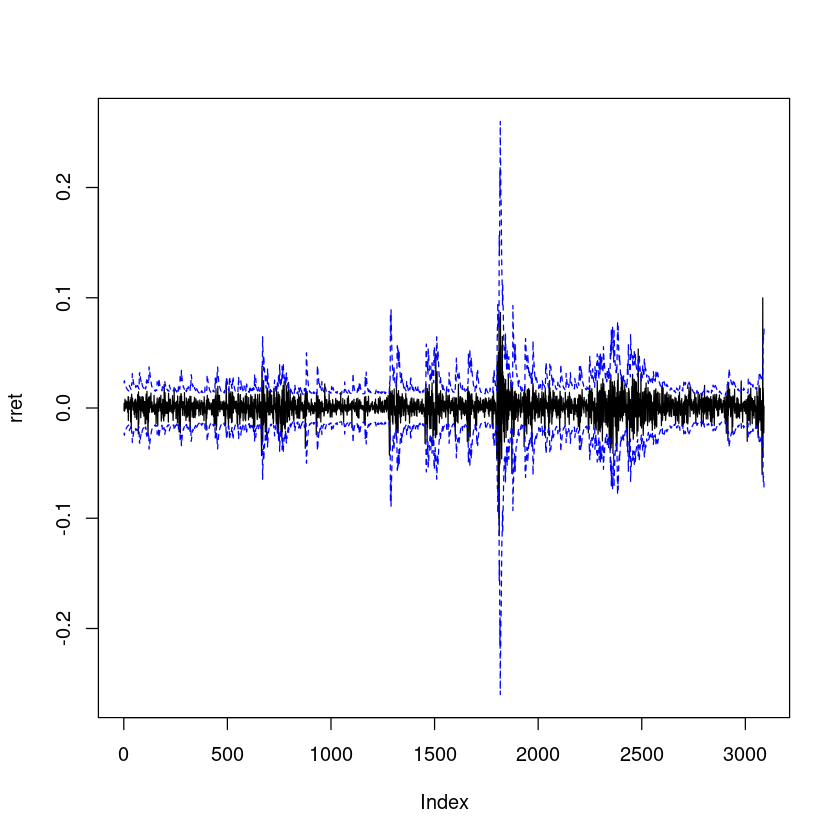

In [206]:
plot(rret, type="l", ylim=range(c(lret, uret, rret)))
lines(lret, col="blue", lty=2)
lines(uret, col="blue", lty=2)


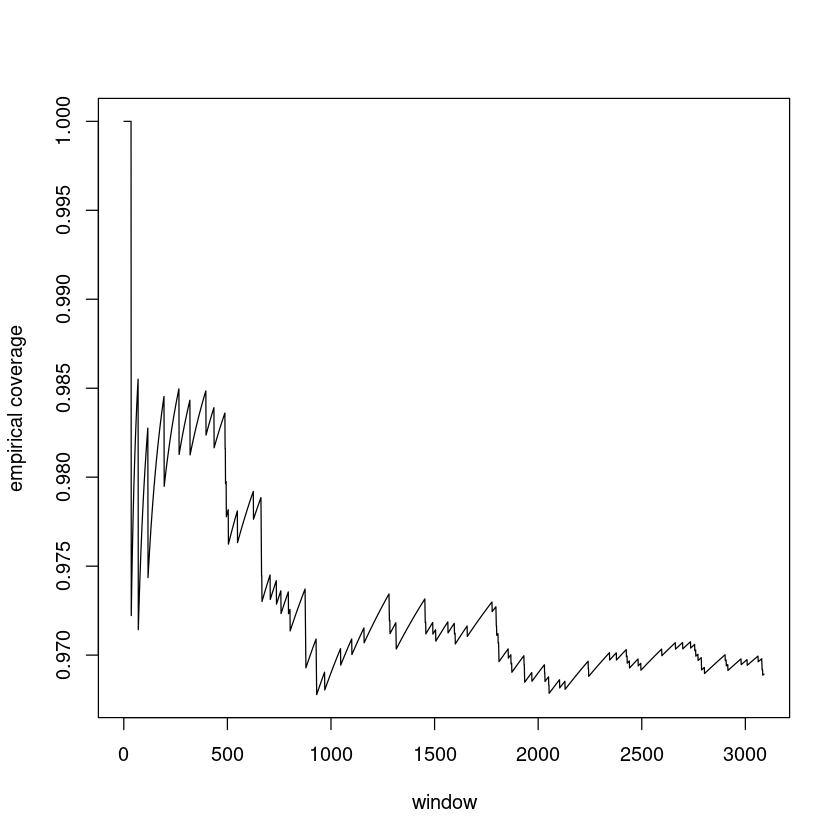

In [209]:
inside <- (rret>=lret & rret<=uret)
plot(cumsum(inside)/(1:length(inside)), type="l",
     ylab="empirical coverage", xlab="window")
abline(h=0.95, col="red")


In [2]:
install.packages("FinTS")

Installazione pacchetto in ‘/home/nicolo/R/x86_64-pc-linux-gnu-library/4.4’
(perché ‘lib’ non è specificato)



[1] "SPY"


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
omega   0.000002    0.000001   1.8879 0.059046
alpha1  0.155004    0.021343   7.2624 0.000000
beta1   0.834601    0.020129  41.4616 0.000000
shape   5.946959    0.605514   9.8213 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
omega   0.000002    0.000005  0.50198 0.615683
alpha1  0.155004    0.059476  2.60615 0.009157
beta1   0.834601    0.062342 13.38749 0.000000
shape   5.946959    0.901891  6.59388 0.000000

LogLikelihood : 12822.75 

Information Criteria
------------------------------------
                    
Akaike       -6.6556
Bayes        -6.6491
Shibata      -6.6556
Hannan-Quinn -6.6533

Weigh

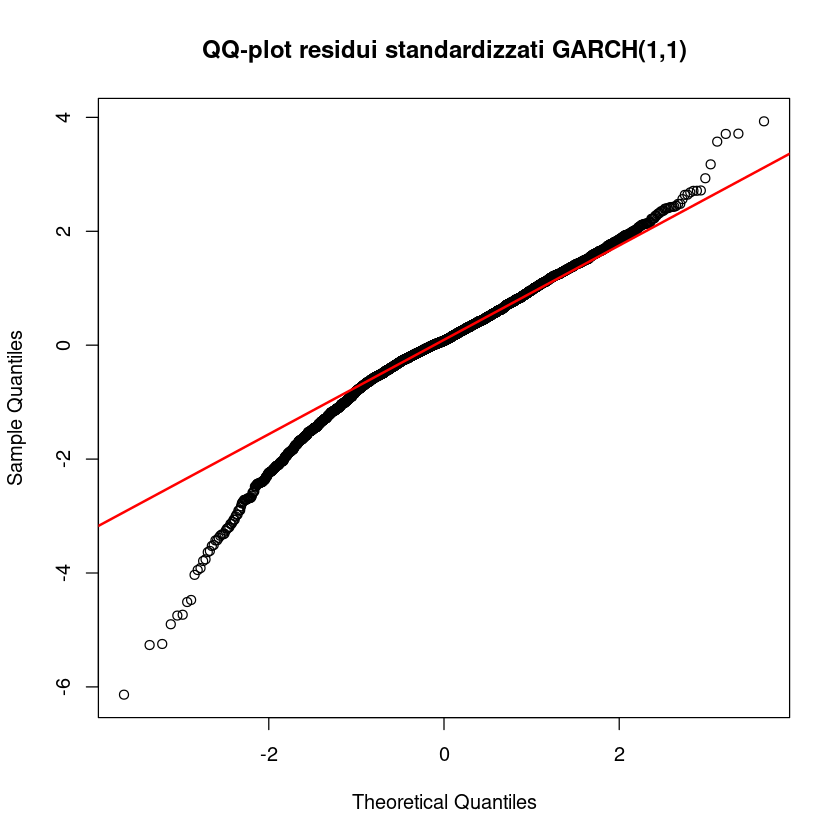

In [ ]:
# install.packages(c("quantmod","rugarch","tseries","moments","FinTS"))
library(quantmod)
library(rugarch)
library(tseries)   # Jarque–Bera
library(moments)   # skewness, kurtosis
library(FinTS)     # jarque.bera.test (più dettagliato)

# 1) scarico i dati e calcolo i log‐returns
getSymbols("SPY", src="yahoo", from="2010-01-01", to=Sys.Date(), auto.assign=TRUE)
spy_ret <- diff(log(Cl(SPY)))
spy_ret <- na.omit(spy_ret)

# 2) specifica GARCH(1,1) con mean=0 e t‐student
spec0 <- ugarchspec(
  mean.model     = list(armaOrder=c(0,0), include.mean=FALSE),
  variance.model = list(model="sGARCH", garchOrder=c(1,1)),
  distribution.model = "std"
)

# 3) stima su tutta la serie
fit0 <- ugarchfit(spec=spec0, data=as.numeric(spy_ret), solver="hybrid", silent=TRUE)
print(fit0)    # riepilogo dei coefficienti, logLik, AIC, ecc.

# 4) estraggo i residui standardizzati
std_resid <- residuals(fit0, standardize=TRUE)
std_resid <- as.numeric(coredata(std_resid))

# 5) diagnostica sui residui “bianchi”
lb1 <- Box.test(std_resid, type="Ljung-Box", lag=20)
lb2 <- Box.test(std_resid^2, type="Ljung-Box", lag=20)

cat("Ljung–Box sui residui:\n");      print(lb1)
cat("Ljung–Box sui residui^2:\n");    print(lb2)

# 6) test di normalità e momenti
sw <- shapiro.test(std_resid)
jb <- jarque.bera.test(std_resid)
sk <- skewness(std_resid)
kt <- kurtosis(std_resid)

cat(sprintf("Shapiro–Wilk: W = %.4f, p = %.3g\n", sw$statistic, sw$p.value))
cat(sprintf("Jarque–Bera: X2 = %.2f, p = %.3g\n", jb$statistic, jb$p.value))
cat(sprintf("Skewness = %.4f   Kurtosis = %.4f\n", sk, kt))

# 7) QQ‐plot dei residui standardizzati
qqnorm(std_resid, main="QQ‐plot residui standardizzati GARCH(1,1)")
qqline(std_resid, col="red", lwd=2)
